In [239]:
import pandas as pd
import sklearn
import numpy as np
import joblib

In [61]:
from sklearn.impute import SimpleImputer

In [63]:
from sklearn.pipeline import Pipeline

In [65]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler

In [67]:
from feature_engine.datetime import DatetimeFeatures

In [69]:
from sklearn.compose import ColumnTransformer

In [125]:
from sklearn.linear_model import LinearRegression

In [205]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [71]:
pd.set_option("display.max_columns",None)

In [73]:
sklearn.set_config(transform_output="default")

In [75]:
train_df=pd.read_csv("data/train.csv")

In [77]:
val_df=pd.read_csv("data/val.csv")

In [79]:
test_df=pd.read_csv("data/test.csv")

In [81]:
def split_data(data):
    X=data.drop(columns="price")
    y=data.price.copy()
    return X,y

In [83]:
X_train,y_train=split_data(train_df)

In [85]:
X_test,y_test=split_data(test_df)
X_val,y_val=split_data(val_df)

In [87]:
X_train.shape

(640, 9)

In [36]:
X_val.shape

(160, 9)

In [38]:
X_test.shape

(200, 9)

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [89]:
dt_cols=['date_of_journey','dep_time','arrival_time']

In [91]:
num_cols=['duration','total_stops']

In [93]:
cat_cols= [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [95]:
num_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

In [109]:
cat_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

In [111]:
doj_transformer= Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["month","day_of_month","day_of_week","week"],format="mixed")),
    ("scaler",StandardScaler())
])

In [113]:
time_transformer= Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["hour","minute"],format="mixed")),
    ("scaler",StandardScaler())
])

In [119]:
preprocessor=ColumnTransformer(transformers=[
    ("num",num_pipe,num_cols),
    ("cat",cat_pipe,cat_cols),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time",time_transformer,["dep_time","arrival_time"])
])

In [121]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

In [123]:
preprocessor.fit_transform(X_train).shape

(640, 33)

In [153]:
algorithms={
    "Linear Regression": LinearRegression(),
    "Support vector machine": SVR(),
    "Random forest": RandomForestRegressor(n_estimators=10),
    "XGBoost": XGBRegressor(n_estimators=10)
}

In [193]:
data=pd.concat([train_df,val_df],axis=0)
X_data,y_data=split_data(data)

In [211]:
def plot_curve(sizes,mean_score,std_score,label,ax):
    ax.plot(
        sizes,
        mean_score,
        marker="o",
        label=label
    )
    ax.fill_between(
        x=sizes,
        y1=mean_score-std_score,
        y2=mean_score+std_score,
        alpha=0.5
    )

In [213]:
def plot_learning_curve(name,algorithm,figsize=(12,4)):
    model=Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])
    train_sizes,train_scores,test_scores=learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )
    mean_train_score=np.mean(train_scores,axis=1)
    std_train_score=np.std(train_scores,axis=1)
    train_score= f"{mean_train_score[-1]:.2f} +/- {std_train_score[-1]:.2f}"
   
    mean_test_score=np.mean(test_scores,axis=1)
    std_test_score=np.std(test_scores,axis=1)
    test_score= f"{mean_test_score[-1]:.2f} +/- {std_test_score[-1]:.2f}"

    fig,ax=plt.subplots(figsize=figsize)
    plot_curve(
        train_sizes,
        mean_train_score,
        std_train_score,
        f"Train: ({train_score})",
        ax
    )
    plot_curve(
        train_sizes,
        mean_test_score,
        std_test_score,
        f"Test: ({test_score})",
        ax
    )
    ax.set(xlabel="training_set_sizes",ylabel="R2-score",title=name)
    ax.legend(loc="lower right")
    plt.show()
    



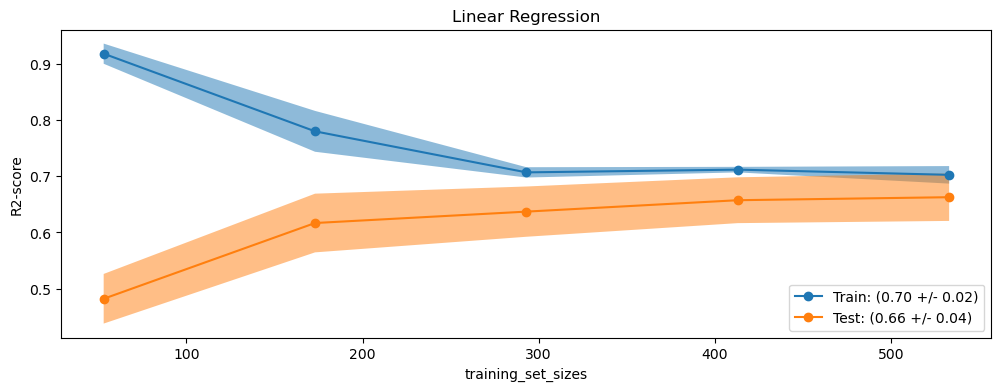

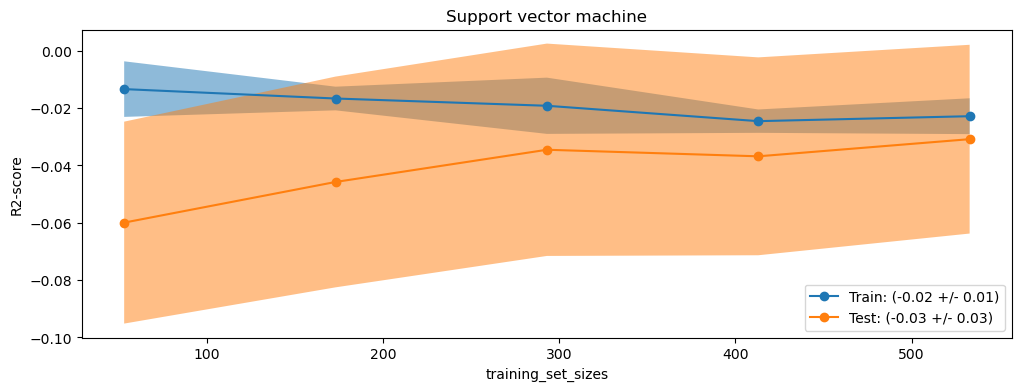

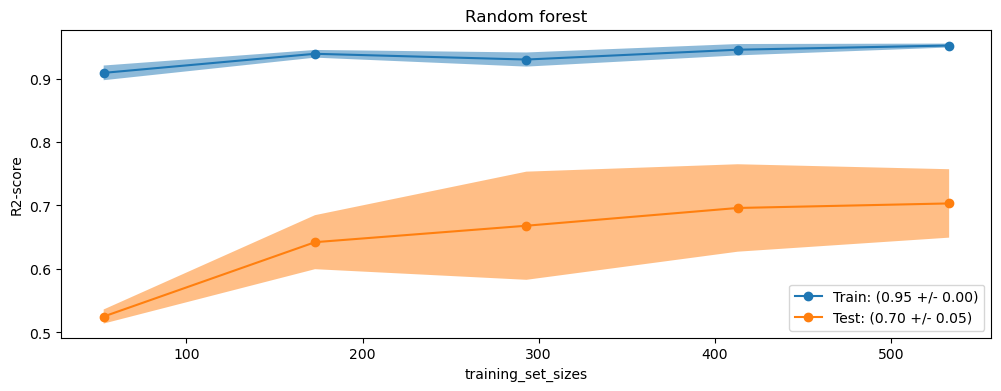

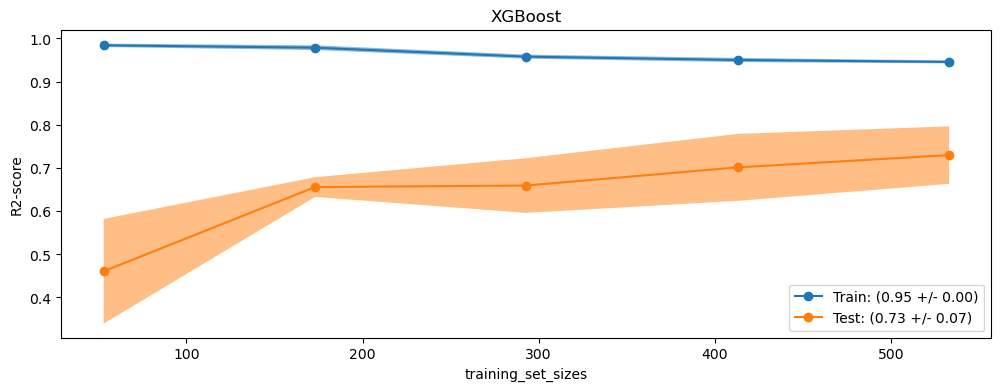

In [215]:
for name,alg in algorithms.items():
    plot_learning_curve(name,alg)

In [229]:
model=Pipeline(steps=[
    ("pre",preprocessor),
    ("rf",RandomForestRegressor(n_estimators=10))
])

In [231]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_week',
                                                                                                         'week'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [233]:
def model_evaluate(X,y):
    y_pred=model.predict(X)
    return r2_score(y,y_pred)

In [235]:
print(f"r2-score on training data is {model_evaluate(X_train,y_train)}")

r2-score on training data is 0.9441650707038046


In [237]:
print(f"r2-score on testing data is {model_evaluate(X_test,y_test)}")

r2-score on testing data is 0.7195915377730528


In [243]:
joblib.dump(model,'model2.joblib')

['model2.joblib']

In [245]:
save_model=joblib.load('model2.joblib')